In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In [2]:
import kurvy

In [3]:
# CONFIG
scale_min = 0
scale_max = 1
train_test_split = (85,15)

## Data Prep

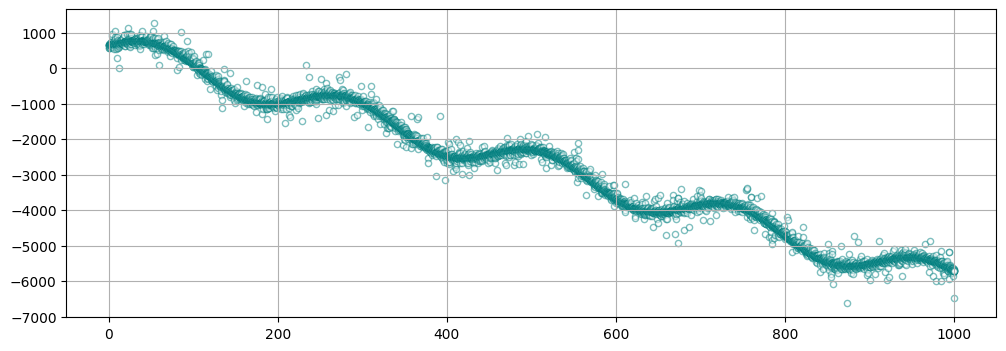

Amplitude: 437.316
Period: 228.67
Phase Shift: 164.911
Vertical Offset: 633.249
Linear Trend: -6.659


In [4]:
# real_params, X_raw, Y_raw = kurvy.trig.make_trig_data((0,100),10000,fuzz=3,seed=66)
real_params, X_raw, Y_raw = kurvy.trig.make_trig_data((0,1000),10000,fuzz=3,seed=None)
kurvy.plots.simple_plot(X_raw, Y_raw)
print(f"Amplitude: {np.round(real_params[0],3)}")
print(f"Period: {np.round(real_params[1],3)}")
print(f"Phase Shift: {np.round(real_params[2],3)}")
print(f"Vertical Offset: {np.round(real_params[3],3)}")
print(f"Linear Trend: {np.round(real_params[4],3)}")

In [5]:
# scale X data
X_raw_min = np.min(X_raw)
X_raw_max = np.max(X_raw)
X = kurvy.utils.min_max_scale(X_raw,scale_min,scale_max,X_raw_min,X_raw_max)
# scale Y data
Y_raw_min = np.min(Y_raw)
Y_raw_max = np.max(Y_raw)
Y = kurvy.utils.min_max_scale(Y_raw,scale_min,scale_max,Y_raw_min,Y_raw_max)
# combine X and Y data
XY = np.dstack((X,Y))[0]

In [6]:
# shuffle data
shuffle_idxs = rng.choice(XY.shape[0],XY.shape[0],replace=False)
XY = XY[shuffle_idxs]

In [7]:
# split data
splits = kurvy.utils.split_n(XY.shape[0],train_test_split)
XY_train = XY[:splits[0]]
X_train = XY_train[:,0]
Y_train = XY_train[:,1]
XY_test = XY[splits[0]:]

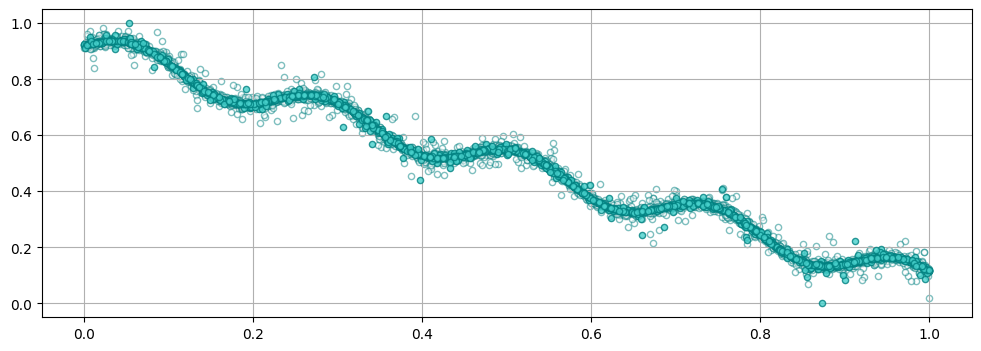

In [8]:
kurvy.plots.simple_plot(X_train,Y_train,test_data=XY_test)

## Parameter Estimiation

In [9]:
# pe = kurvy.trig.ParamEstimator()
# pe.fit(X_train,Y_train,window_size=100,sort_data=True)
# pe.plot()

## Training

In [10]:
# parameter initialization using smart init
tm = kurvy.trig.TrigModel(smart_init=True)

### Untrained model

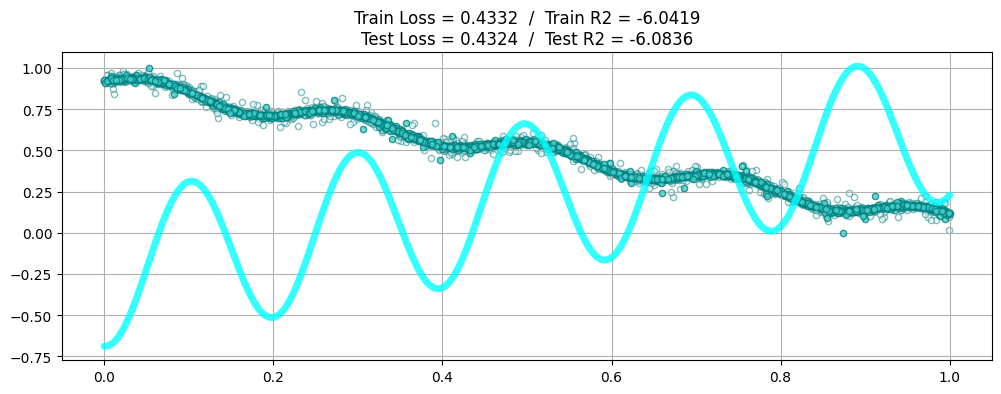

In [11]:
kurvy.plots.pred_plot(tm,X_train,Y_train,test_data=XY_test)

### Training run

Initial Loss: 0.0001494333275343511


100%|███████████████████████████████████████| 1000/1000 [00:12<00:00, 78.33it/s]


Final Loss: 0.0001222457472541652


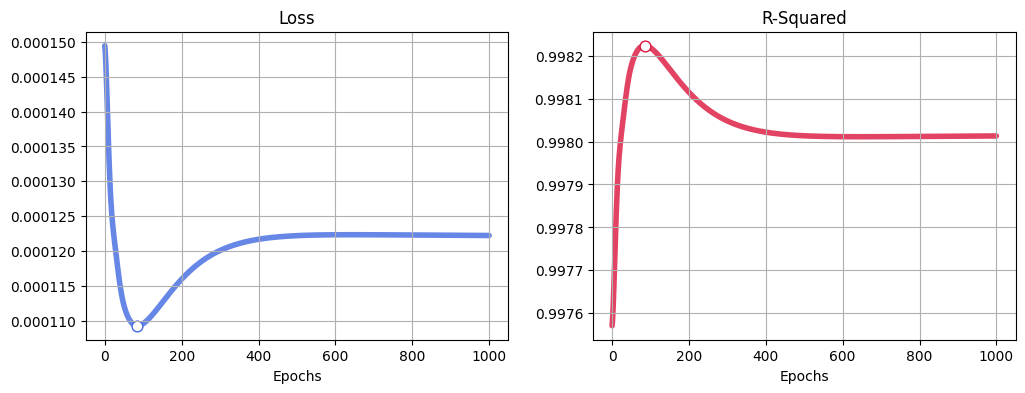

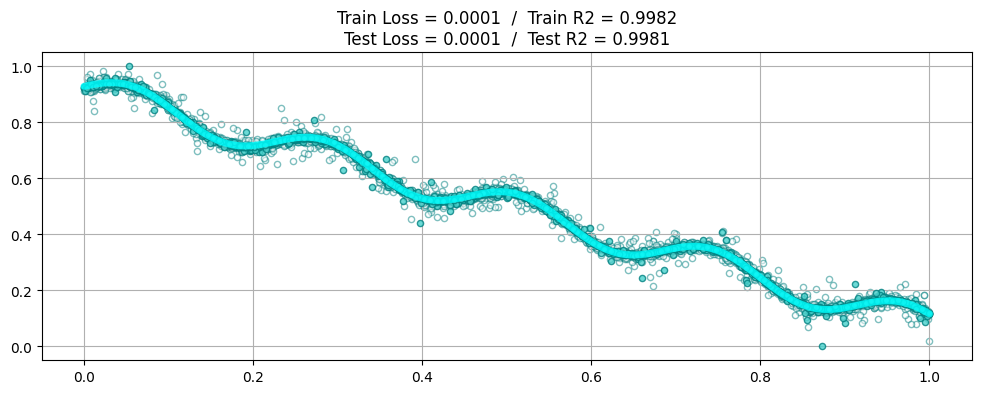

In [12]:
tm.fit(
    X_train,
    Y_train,
    epochs=1000,
    learning_rate=0.001,
    momentum=0.9,
    lambda_2={"a":-0.9},
    save_best=True,
    window_size=200
)
kurvy.plots.plot_training(tm,"both")
kurvy.plots.pred_plot(tm,X_train,Y_train,test_data=XY_test)

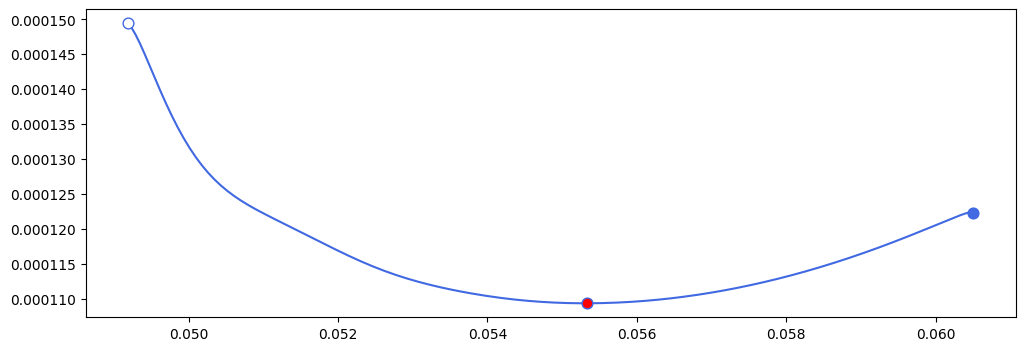

In [13]:
kurvy.plots.loss_vis(tm,"a",markers=False)

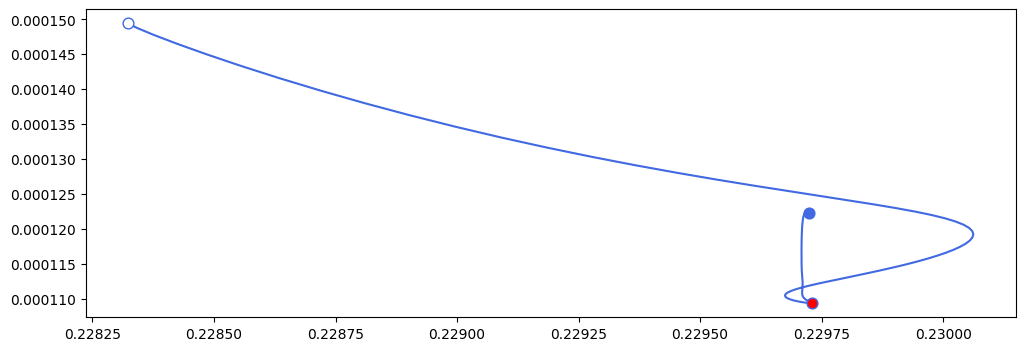

In [14]:
kurvy.plots.loss_vis(tm,"b",markers=False)

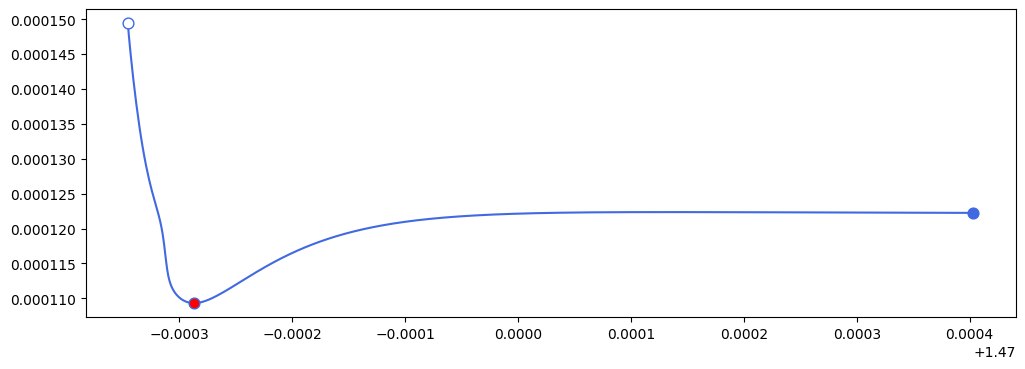

In [15]:
kurvy.plots.loss_vis(tm,"c",markers=False)

## Descale Parameters

In [16]:
a = tm.params["a"]["value"]
b = tm.params["b"]["value"]
c = tm.params["c"]["value"]
d = tm.params["d"]["value"]
e = tm.params["e"]["value"]

In [17]:
alpha_x = X_raw_max - X_raw_min
beta_x = X_raw_min
alpha_y = Y_raw_max - Y_raw_min
beta_y = Y_raw_min

In [18]:
a_pred = a * alpha_y
b_pred = b * alpha_x + beta_x
c_pred = c
d_pred = alpha_y * (d - e*beta_x/alpha_x) + beta_y
e_pred = alpha_y * e / alpha_x

In [19]:
a_real, b_real, c_real, d_real, e_real = real_params
for param in [
    ("a",a_real,a_pred),
    ("b",b_real,b_pred),
    ("c",c_real,c_pred),
    ("d",d_real,d_pred),
    ("e",e_real,e_pred),
]:
    p_real = np.round(param[1],3)
    p_pred = np.round(param[2],3)
    dif = np.round(p_real - p_pred,3)
    dif_pct = np.round(dif/p_real*100,2)
    
    print(f"{param[0]}\treal: {p_real}\tpred: {p_pred}")  

a	real: 437.316	pred: 436.537
b	real: 228.67	pred: 229.73
c	real: 164.911	pred: 1.47
d	real: 633.249	pred: 652.845
e	real: -6.659	pred: -6.688
